# CO2 Emissions Tracker

This will will contain:
- Data extraction 
- Data visualation 
- Dataset creation 
- Model preperation
- Training algorithm 
- Model testing
- Model preview

# Note

In order to run the code, ensure a python environment is created and install the required packaged. 

## EDA 

### Data Perperation

### Importing plugins

In [1]:
import pandas as pd
import numpy as np 
import torch
import torch.nn as nn
import lightning as l 
import matplotlib.pyplot as plt 
import plotly.express as px
pd.options.plotting.backend = "plotly"
pd.options.display.max_columns = 200
import seaborn as sns





### Step 1. Data Cleanup, and standardizing the format

In [2]:
# loading in the data

#importing CO2 emissions data
co2_emission_data = pd.read_csv(filepath_or_buffer='./data/Annual CO2 Emissions.csv')
gdp_data = pd.read_csv('./data/gdp/gdp_data.csv')
land_size =  pd.read_csv('./data/world_country_stats.csv')
surface_temp = pd.read_csv('./data/temperature/monthly-average-surface-temperatures-by-year.csv')
population = pd.read_csv('./data/population.csv')
research_spending = pd.read_csv('./data/research-spending-gdp.csv')
energy_use_per_capita = pd.read_csv('./data/per-capita-energy-use.csv')
land_use = pd.read_csv('./data/land_use.csv')
trade = pd.read_csv('./data/Trade.csv')
urban_population = pd.read_csv('./data/urban_population.csv')


In [3]:
# gdp_data[['country_name',  'country_code' , 'year', 'value']]
land_size = land_size[['country', 
                       #'region', 
                       'land_area', 
                       #'fertility_rate', 'median_age'
                       ]].copy()

co2_emission_data = co2_emission_data[['Entity', 'Code', 'Year', 'Annual CO2 Emissions (tonnes)']].copy()

In [4]:
## this section of code is to determine the year range for the different datasets
## the suitable range has been chosen such that we are getting the maximum of the oldest year, and minimum of the most current year, 
## this ensures we avoid having too many missing values

temp_years = [int(col) for col in surface_temp.columns if col.isdigit()]

year_ranges = {
    'CO2': (co2_emission_data['Year'].min(), co2_emission_data['Year'].max()),
    'GDP': (gdp_data['year'].min(), gdp_data['year'].max()),
    'Temperature': (min(temp_years), max(temp_years)),
    'Population': (population['Year'].min(), population['Year'].max()),
    # 'Research Spending' : (research_spending['Year'].min(), research_spending['Year'].max()),
    'energy_use_per_capita' : (energy_use_per_capita['Year'].min(), energy_use_per_capita['Year'].max()),
    'land_use' : (land_use['Year'].min(), land_use['Year'].max()),
    'trade' : (trade['Year'].min(), trade['Year'].max()),
    'urban_population' : (urban_population['Year'].min(), urban_population['Year'].max()),
    # 'per_capita_energy_source' : (per_capita_energy_source['Year'].min(), per_capita_energy_source['Year'].max()),
    }

# Print current ranges
for dataset, (start, end) in year_ranges.items():
    print(f"{dataset}: {start} - {end}")

# Calculate optimal range
optimal_start = max(range[0] for range in year_ranges.values())
optimal_end = min(range[1] for range in year_ranges.values())

print(f"\nOptimal year range: {optimal_start} - {optimal_end}")

CO2: 1750 - 2022
GDP: 1960 - 2022
Temperature: 1950 - 2024
Population: -10000 - 2023
energy_use_per_capita: 1965 - 2023
land_use: -10000 - 2023
trade: 1960 - 2022
urban_population: 1960 - 2022

Optimal year range: 1965 - 2022


In [5]:
# creating a function to standardize the datasets, so code is not repeated below. 
def std_dataset(df,id_columns,value_column, year_column='year'):
    # input of id_column should be: country, iso3
    if df[year_column].dtype != 'int64':
        df[year_column] = pd.to_numeric(df[year_column],errors='coerce')
    
    #filtering for optimal range
    df_filtered = df[
                    (df[year_column] >= optimal_start) &
                    (df[year_column] <= optimal_end)]
    
    # sorting by country code and year
    df_filtered = df_filtered.sort_values([id_columns[1],year_column])

    return df_filtered


In [6]:
# reshaping the surface temperature dataset o that it is in long format (countries are the rows, years are the columns) 
surface_temp_long = surface_temp.melt(id_vars=['Entity', 'Code', 'Month'], var_name='Year', value_name='Temperature')

#converting year to integer, and filtering out the optimal range
surface_temp_long['Year'] = pd.to_numeric(surface_temp_long['Year'],errors='coerce')
surface_temp_long = surface_temp_long[
                                        (surface_temp_long['Year'] >= optimal_start) &
                                        (surface_temp_long['Year'] <= optimal_end)]
surface_temp_long = surface_temp_long.sort_values(['Code', 'Year'])
surface_temp_long = surface_temp_long.groupby(['Entity', 'Code', 'Year'])['Temperature'].mean().reset_index().copy()



# Reshaping CO2 emissions to be in long format as well as optimal years
co2_long = std_dataset(co2_emission_data, id_columns=['Entity', 'Code'], value_column='Annual CO2 Emissions (tonnes)', year_column='Year')

# Reshaping GDP to be in long format as well as optimal years:
gdp_long = std_dataset(gdp_data,id_columns=['country_name', 'country_code'],value_column='value', year_column='year')


population_long  = std_dataset(population, id_columns=['Entity', 'Code'], value_column= 'Population (historical)', year_column='Year')

research_spending_long  = std_dataset(research_spending, id_columns=['Entity', 'Code'], value_column= 'R&D Spending', year_column='Year')

energy_use_per_capita_long = std_dataset(energy_use_per_capita, id_columns=['Entity', 'Code'], value_column= 'Primary energy consumption per capita (kWh/person)', year_column='Year')

land_use_long = std_dataset(land_use, id_columns=['Country', 'ISO'], value_column= ['Land use: Built-up area', 'Land use: Grazingland', 'Land use: Cropland'], year_column='Year')

trade_long = std_dataset(trade, id_columns=['Country', 'ISO'], value_column= ['Trade in services (% of GDP)'], year_column='Year')

urban_population_long = std_dataset(urban_population, id_columns=['Country', 'ISO'], value_column= ['Urban population (% of total population)'], year_column='Year')




# Renaming the columns so its standardized: 
surface_temp_long.rename(columns={'Code' : 'ISO', 'Year' : 'Year', 'Entity' : 'Country'},inplace=True)
co2_long.rename(columns={'Entity' : 'Country', 'Code' : 'ISO'}, inplace= True)
gdp_long.rename(columns={'country_name' : 'Country', 'country_code' : 'ISO', 'year' : 'Year', 'value' : 'GDP'}, inplace= True)
population_long.rename(columns={'Entity' : 'Country', 'Code' : 'ISO', 'Population (historical)' : 'Population' }, inplace= True)
research_spending_long.rename(columns={'Code' : 'ISO', 'Year' : 'Year', 'Entity' : 'Country', 'Research and development expenditure (% of GDP)' : 'R&D Spending'},inplace=True)
energy_use_per_capita_long.rename(columns={'Code' : 'ISO', 'Year' : 'Year', 'Entity' : 'Country'},inplace=True)




In [7]:

# creating country codes index
country_codes = co2_long.set_index(['ISO'])
country_codes = country_codes.drop(axis='columns', labels=['Year','Annual CO2 Emissions (tonnes)'])
country_codes.drop_duplicates(keep='first', inplace=True, ignore_index=False)

country_mapping = country_codes['Country'].to_dict()



In [8]:
# in this section of the code, I am combining all the datasets based on the country ISO codes, as they are there for majority of the data, and should be standardized.  
# The 
def merge_df(base_df,new_df,values):
    # get unique ISOs from base df
    base_df_ISO_count = base_df.ISO.unique().size
    new_df_ISO_count = new_df.ISO.unique().size

    # creating sets for easier comparison 
    base_iso_set = set(base_df.ISO.unique())
    new_iso_set = set(new_df.ISO.unique())

    matching_ISOs = base_iso_set.intersection(new_iso_set)
    missing_ISOs = base_iso_set.difference(new_iso_set)
    
    initial_stats = {
        'base_df_countries' : base_df_ISO_count,
        'new_df_countries' : new_df_ISO_count,
        'matching_countries': len(matching_ISOs),
        'missing_countries' : len(missing_ISOs)
    }

    # merging the columns
    merged_df = base_df.merge(
                                new_df[['ISO', 'Year'] + values],
                                on=['ISO', 'Year'],
                                how='left'
    )


     # Track final stats
    final_iso_count = merged_df.ISO.unique().size
    
    merge_stats = {
        **initial_stats,
        'final_countries': final_iso_count,
        'missing_iso_list': list(missing_ISOs)
    }
    
    return merged_df, merge_stats




    

In [9]:
#converting the per capita or percentage value to whole figures for consistent comparison. 
energy_use_per_capita_long['Primary energy consumption (kWh)'] = energy_use_per_capita_long['Primary energy consumption per capita (kWh/person)'] * population_long['Population']

trade_long['Trade in services ($)'] = (trade_long['Trade in services (% of GDP)']/100) * gdp_long['GDP']

urban_population_long['Urban population (people)'] = (urban_population_long['Urban population (% of total population)']/100) * population_long['Population']



In [10]:
dataset, stats = merge_df(base_df=co2_long, new_df=gdp_long, values=['GDP'])
print(stats)
dataset,stats = merge_df(base_df=dataset, new_df=surface_temp_long, values=['Temperature'])
print(stats)

dataset, stats = merge_df(base_df=dataset, new_df=population_long, values=['Population'])
print(stats)

dataset, stats = merge_df(base_df=dataset, new_df=research_spending_long, values=['R&D Spending'])
print(stats)

print(stats)

dataset, stats = merge_df(base_df=dataset, new_df=energy_use_per_capita_long, values=['Primary energy consumption per capita (kWh/person)' , 'Primary energy consumption (kWh)'])
print(stats)

dataset, stats = merge_df(base_df=dataset, new_df=land_use_long, values=['Land use: Built-up area', 'Land use: Grazingland', 'Land use: Cropland'])
print(stats)

dataset, stats = merge_df(base_df=dataset, new_df=trade_long, values=['Trade in services ($)'])
print(stats)

dataset, stats = merge_df(base_df=dataset, new_df=urban_population_long, values=['Urban population (% of total population)'])
print(stats)




# creating a filtered dataset which doesnt include world 
filtered_dataset = dataset[dataset['ISO'] != 'WLD']



{'base_df_countries': 217, 'new_df_countries': 262, 'matching_countries': 203, 'missing_countries': 14, 'final_countries': 217, 'missing_iso_list': ['BES', 'VGB', 'NIU', 'SPM', 'CXR', 'MSR', 'SHN', 'ATA', 'TWN', 'COK', 'PRK', 'KOS', 'AIA', 'WLF']}
{'base_df_countries': 217, 'new_df_countries': 195, 'matching_countries': 186, 'missing_countries': 31, 'final_countries': 217, 'missing_iso_list': ['BRB', 'SGP', 'ABW', 'CXR', 'KOS', 'SPM', 'VGB', 'FSM', 'LCA', 'MAC', 'GRD', 'DMA', 'TUV', 'ATA', 'MDV', 'BMU', 'MHL', 'NRU', 'PLW', 'TCA', 'MSR', 'TON', 'MLT', 'LIE', 'SXM', 'KNA', 'BES', 'NIU', 'TWN', 'CUW', 'WLF']}
{'base_df_countries': 217, 'new_df_countries': 251, 'matching_countries': 214, 'missing_countries': 3, 'final_countries': 217, 'missing_iso_list': ['ATA', 'KOS', 'CXR']}
{'base_df_countries': 217, 'new_df_countries': 151, 'matching_countries': 145, 'missing_countries': 72, 'final_countries': 217, 'missing_iso_list': ['TKM', 'YEM', 'BRB', 'ABW', 'CXR', 'CMR', 'BEN', 'LBY', 'SOM', 'WS

In [11]:
fig = px.line(co2_long, 
              x='Year',              # specify x-axis column
              y='Annual CO2 Emissions (tonnes)',  # specify y-axis column
              color='ISO',          # use this to create different lines per country
              title='CO2 Emissions by Country (log y scale)',
              width=1500,
              height=1000,
              log_y=True)
# Create custom hover template
fig.update_traces(
    hovertemplate="Country: %{customdata}<br>" +
                  "Year: %{x}<br>" +
                  "CO2 Emissions: %{y:,.2f} tonnes<br>" +
                  "<extra></extra>"
)

# Update the trace names using your mapping
for trace in fig.data:
    # Get current name (country code) and find corresponding country name
    country_code = trace.name
    country_name = country_mapping.get(country_code, country_code)  # fallback to code if not found
    trace.name = country_name
    trace.customdata = [[country_name, country_code] for _ in range(len(trace.x))]


# Update layout with better labels
fig.update_layout(
    xaxis_title="Year",
    yaxis_title="CO2 Emissions (t)",
    title_x=0.5,  # Center the title
)

# Show the plot
fig.show()

In [12]:
# the code for generating unique colours was retrieved from Claude Sonnet 3.5 to ensure we have somewhat unique colours for the different countries. 
def generate_unique_colors(n):
    colors = []
    
    # Use different color spaces to ensure variety
    # RGB space variations
    for i in range(n):
        # Use prime numbers to space out the colors
        r = (173 + i * 71) % 256  # Prime number 71
        g = (223 + i * 67) % 256  # Prime number 67
        b = (157 + i * 73) % 256  # Prime number 73
        
        # Adjust vibrancy by mixing less with white
        # Change these ratios to adjust vibrancy (higher ratio = more vibrant)
        # Original was 0.5 (dividing by 2), let's try 0.7
        white_mix = 0.3  # Reduce white mixing for more vibrant colors
        r = int(r * (1 - white_mix) + 255 * white_mix)
        g = int(g * (1 - white_mix) + 255 * white_mix)
        b = int(b * (1 - white_mix) + 255 * white_mix)
        
        colors.append(f'rgb({r}, {g}, {b})')
    
    return colors

# First verify the number of colors generated
colors = generate_unique_colors(217)
print("Number of unique colors:", len(set(colors)))  # Should be 217

# Create the plot
fig = px.scatter_3d(dataset, 
                    x='Annual CO2 Emissions (tonnes)', 
                    log_x= True,
                    y='GDP',
                    log_y=True, 
                    z='Year',
                    color='Country',
                    width=1500,
                    height=1000,
                    color_discrete_sequence=colors,
                    title="Comparison of CO2 Emissions, Country's GDP and Time"
                   )
# # Define which countries you want visible initially
# initial_countries = ['China', 'United States', 'Australia', 'India', 'Russia', 'Japan', 'South Korea']  # Example countries

# # Update traces to set initial visibility
# fig.update_traces(visible='legendonly')  # First set all to hidden
# for trace in fig.data:
#     if trace.name in initial_countries:
#         trace.visible = True  # Make selected countries visible

fig.show()

Number of unique colors: 217


<Axes: >

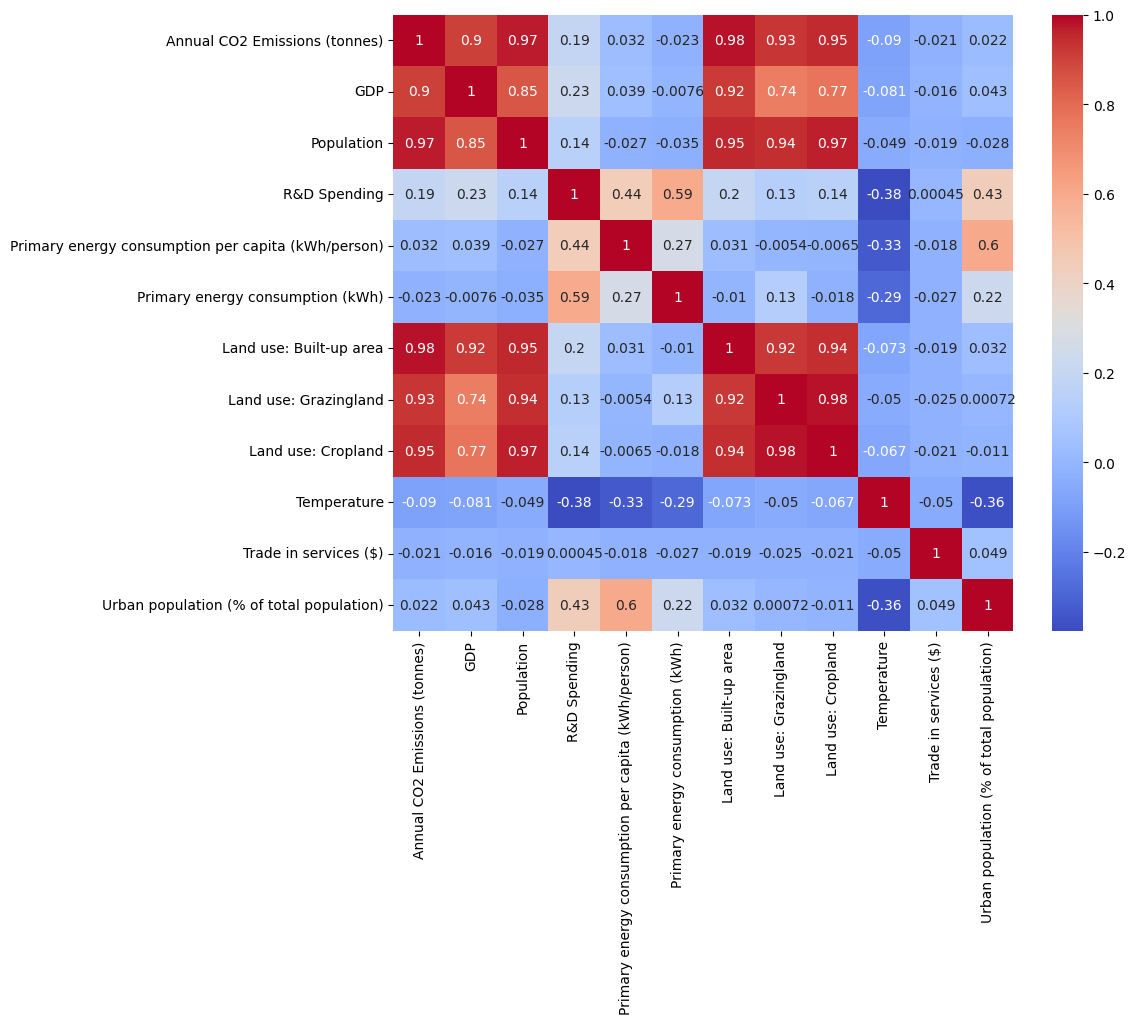

In [13]:
# Correlation heatmap
import seaborn as sns

correlation_matrix = dataset[['Annual CO2 Emissions (tonnes)', 'GDP', 'Population', 'R&D Spending' , 'Primary energy consumption per capita (kWh/person)' , 'Primary energy consumption (kWh)' ,
                              'Land use: Built-up area', 'Land use: Grazingland', 'Land use: Cropland' ,  'Temperature' , 'Trade in services ($)', 'Urban population (% of total population)']].corr()

plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

<Axes: >

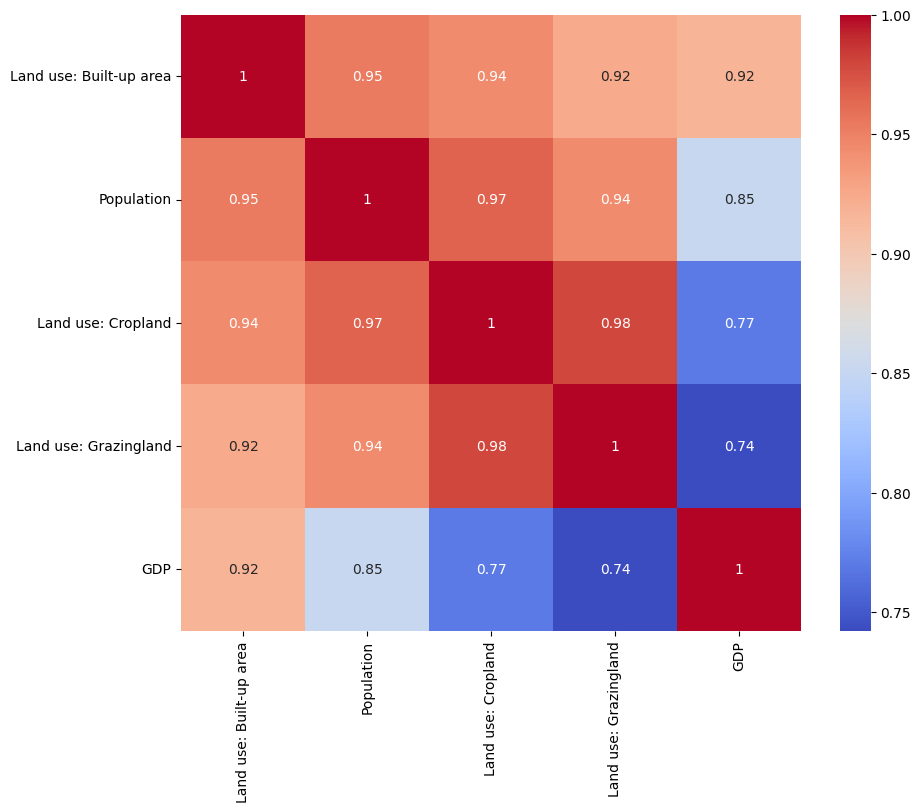

In [14]:
primary_features = [
    'Land use: Built-up area',
    'Population',
    'Land use: Cropland',
    'Land use: Grazingland',
    'GDP'
]


# Correlation heatmap
import seaborn as sns

correlation_matrix = dataset[primary_features].corr()

plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Applying Log and per capita transformation in order to normally distribute the dataset vales

Right now the dataset is right skewed (a large tail on the right) this is particurlaly becuase of the world figures which would be the sum of all country figures. It is also a problem because different countires have different economies of scale, right now this is not taken into consideration so countries with higher population or GDP can skew the dataset. 

### Applying Per Capita Transformation


Missing values in final dataset:
Country                                 0
ISO                                     0
Year                                    0
CO2_per_capita_log                     54
GDP_per_capita_log                   2419
Trade_services_per_capita_log        5448
Energy_consumption_per_capita_log    2804
ag_to_built_ratio_log                1254
Land_use_built_up_per_capita_log     1254
Land_use_grazing_per_capita_log      1254
Land_use_crop_per_capita_log         1254
Urban_population_pct                  560
RnD_spending_pct                     9909
Temperature                          1547
Temperature_anomaly                  1547
Temperature_change                   1733
dtype: int64


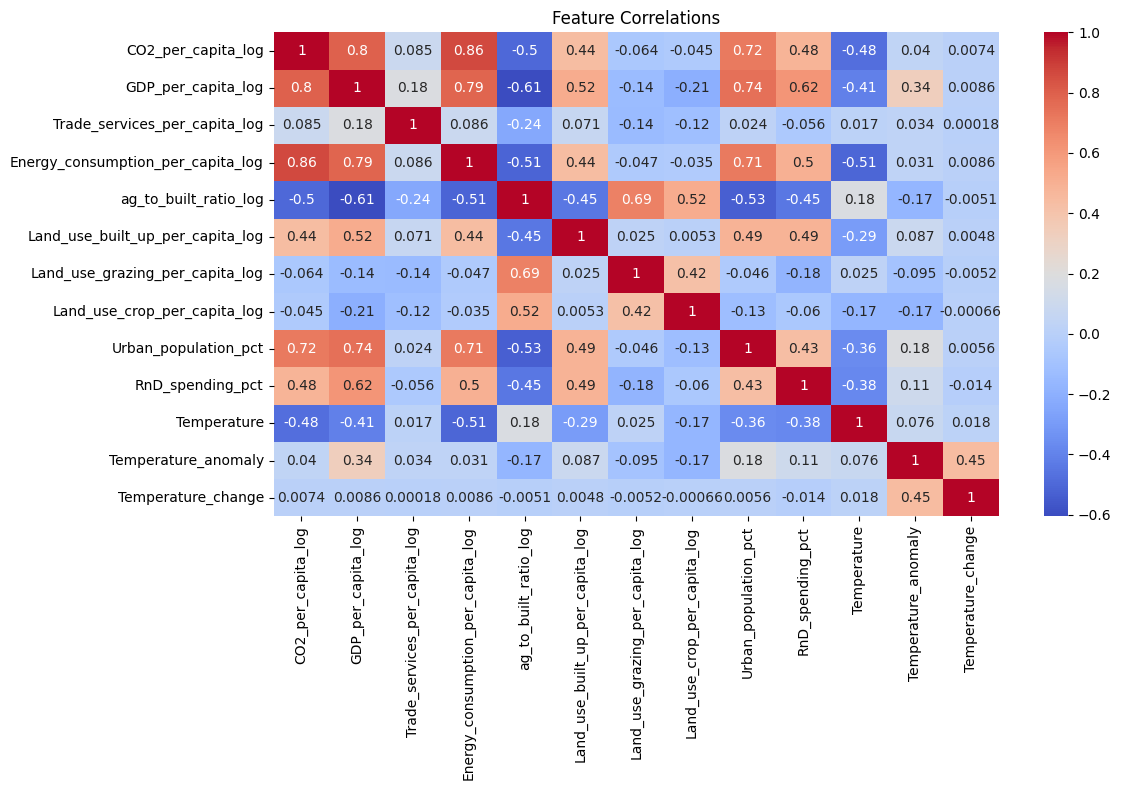


Correlations with CO2 per capita (log):
Temperature: -0.479
Temperature_anomaly: 0.040
Temperature_change: 0.007

Correlation between agricultural/built-up ratio and CO2 per capita: -0.503


In [15]:
# First, create a copy with base columns
transformed_dataset = dataset[['Country', 'ISO', 'Year']].copy()

# Features that should be per capita
transformed_dataset['CO2_per_capita'] = dataset['Annual CO2 Emissions (tonnes)'] / dataset['Population']
transformed_dataset['GDP_per_capita'] = dataset['GDP'] / dataset['Population']
transformed_dataset['Trade_services_per_capita'] = dataset['Trade in services ($)'] / dataset['Population']

# Keep percentage features as they are (already normalized)
transformed_dataset['Urban_population_pct'] = dataset['Urban population (% of total population)']
transformed_dataset['RnD_spending_pct'] = dataset['R&D Spending']

# Keep per capita features that are already normalized
transformed_dataset['Energy_consumption_per_capita'] = dataset['Primary energy consumption per capita (kWh/person)']

# Temperature features
transformed_dataset['Temperature'] = dataset['Temperature']

# Calculate temperature change features
# 1. Calculate baseline temperature (average for each country)
temp_baseline = dataset.groupby('Country')['Temperature'].mean().reset_index()
temp_baseline.columns = ['Country', 'Temp_baseline']

# 2. Merge baseline with transformed dataset
transformed_dataset = transformed_dataset.merge(temp_baseline, on='Country', how='left')

# 3. Calculate temperature anomaly (difference from baseline)
transformed_dataset['Temperature_anomaly'] = transformed_dataset['Temperature'] - transformed_dataset['Temp_baseline']

# 4. Calculate year-over-year temperature change
transformed_dataset['Temperature_change'] = transformed_dataset.groupby('Country')['Temperature'].diff()

# Drop the temporary baseline column
transformed_dataset = transformed_dataset.drop('Temp_baseline', axis=1)

# Land use transformations
transformed_dataset['Land_use_built_up_per_capita'] = (dataset['Land use: Built-up area']) / dataset['Population']
transformed_dataset['Land_use_grazing_per_capita'] = (dataset['Land use: Grazingland']) / dataset['Population']
transformed_dataset['Land_use_crop_per_capita'] = (dataset['Land use: Cropland']) / dataset['Population']

# Calculate agricultural to built-up ratio
transformed_dataset['ag_to_built_ratio'] = (dataset['Land use: Grazingland'] + dataset['Land use: Cropland']) / dataset['Land use: Built-up area']
transformed_dataset['ag_to_built_ratio_log'] = np.log1p(transformed_dataset['ag_to_built_ratio'])

# Log transform per capita features
per_capita_columns = [
    'CO2_per_capita',
    'GDP_per_capita',
    'Trade_services_per_capita',
    'Energy_consumption_per_capita',
    'Land_use_built_up_per_capita',
    'Land_use_grazing_per_capita',
    'Land_use_crop_per_capita'
]

for col in per_capita_columns:
    transformed_dataset[f'{col}_log'] = np.log1p(transformed_dataset[col])

# Create final dataset with only the columns we need
final_columns = [
    # Identifying columns
    'Country', 'ISO', 'Year',
    
    # Target variable
    'CO2_per_capita_log',
    
    # Per capita log-transformed features
    'GDP_per_capita_log',
    'Trade_services_per_capita_log',
    'Energy_consumption_per_capita_log',
    
    # Land use features
    'ag_to_built_ratio_log',  # New ratio feature
    'Land_use_built_up_per_capita_log',
    'Land_use_grazing_per_capita_log',
    'Land_use_crop_per_capita_log',
    
    # Percentage features (already normalized)
    'Urban_population_pct',
    'RnD_spending_pct',
    
    # Temperature features
    'Temperature',
    'Temperature_anomaly',
    'Temperature_change'
]

final_dataset = transformed_dataset[final_columns].copy()

# Check for any missing values in final dataset
print("\nMissing values in final dataset:")
print(final_dataset.isnull().sum())

# Create correlation matrix for the features
correlation_matrix = final_dataset.drop(['Country', 'ISO', 'Year'], axis=1).corr()

# Plot correlation matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlations')
plt.tight_layout()
plt.show()

# Print correlations with CO2 emissions for temperature features
print("\nCorrelations with CO2 per capita (log):")
for temp_col in ['Temperature', 'Temperature_anomaly', 'Temperature_change']:
    corr = final_dataset[temp_col].corr(final_dataset['CO2_per_capita_log'])
    print(f"{temp_col}: {corr:.3f}")

# Print correlation between agricultural ratio and CO2
corr = final_dataset['ag_to_built_ratio_log'].corr(final_dataset['CO2_per_capita_log'])
print(f"\nCorrelation between agricultural/built-up ratio and CO2 per capita: {corr:.3f}")

In [16]:
# Let's look at the ratio of agricultural to built-up land
transformed_dataset['ag_to_built_ratio'] = (dataset['Land use: Grazingland'] + dataset['Land use: Cropland']) / dataset['Land use: Built-up area']
transformed_dataset['ag_to_built_ratio_log'] = np.log1p(transformed_dataset['ag_to_built_ratio'])

# Check correlation
corr = transformed_dataset['ag_to_built_ratio_log'].corr(transformed_dataset['CO2_per_capita_log'])
print(f"\nCorrelation between agricultural/built-up ratio and CO2 per capita: {corr}")


Correlation between agricultural/built-up ratio and CO2 per capita: -0.5030917227326329


In [17]:
final_dataset = final_dataset.drop(columns=['Temperature', 'Temperature_anomaly', 'Temperature_change', 'Trade_services_per_capita_log', 'Land_use_built_up_per_capita_log', 'Land_use_grazing_per_capita_log', 'Land_use_crop_per_capita_log'])


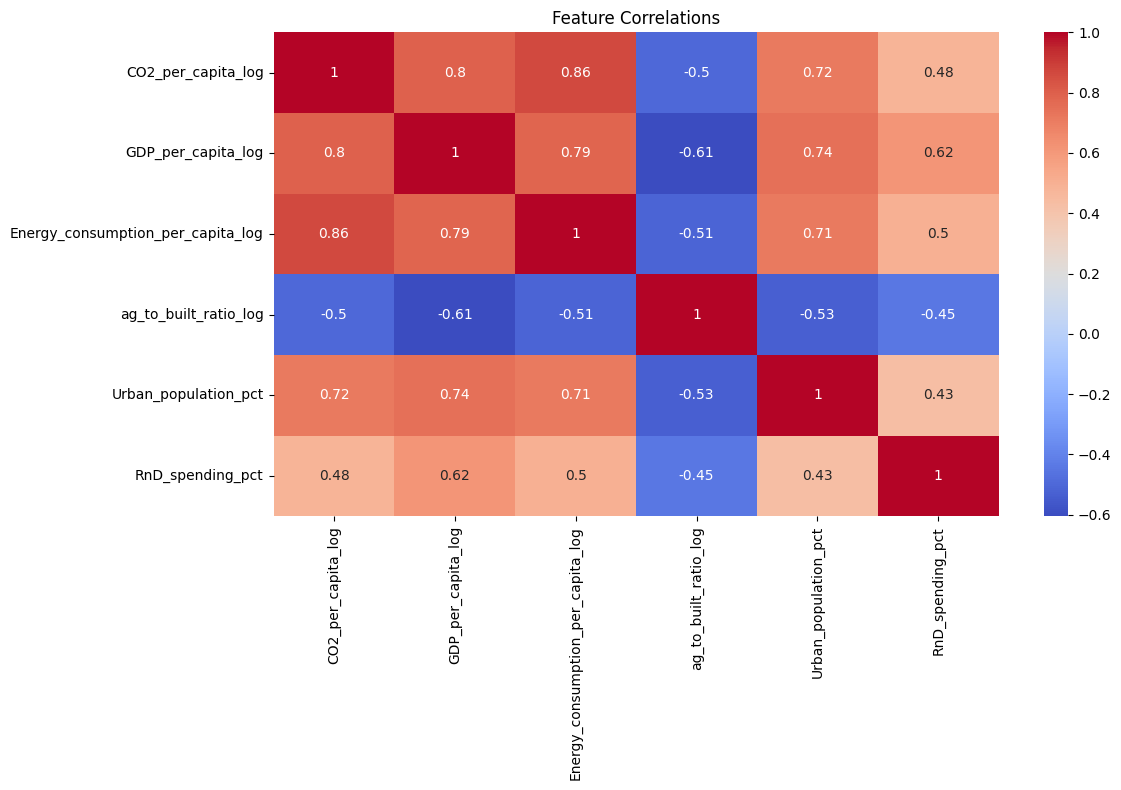

In [18]:
correlation_matrix = final_dataset.drop(['Country', 'ISO', 'Year'], axis=1).corr()

# Plot correlation matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlations')
plt.tight_layout()
plt.show()

### Additional Notes on Temperature Removal:

1. **Geographic vs Temporal Patterns**:
   - Temperature showed negative correlation (-0.48) with CO2 emissions
   - This contradicts known climate science where CO2 increases temperature
   - The negative correlation reflects geographic patterns:
     * High-emission countries often in cooler climates (e.g., US, Europe)
     * Lower-emission countries often in warmer climates (e.g., tropical regions)
   - Dataset captures spatial patterns rather than temporal climate change

2. **Scale and Time Lag Issues**:
   - Climate change operates on:
     * Global rather than country level
     * Longer time scales (decades to centuries)
     * With significant time lags between emissions and temperature changes
   - Our dataset is:
     * Country-specific
     * Relatively short time period
     * Without accounting for global circulation patterns

3. **Data Structure Limitations**:
   - No regional/latitude-based grouping
   - No consideration of seasonal variations
   - No distinction between:
     * Natural temperature variations
     * Anthropogenic climate change
   - Missing important context like:
     * Ocean currents
     * Global wind patterns
     * Other greenhouse gases

4. **Attempted Solutions**:
   - Tried multiple temperature metrics:
     * Absolute temperature
     * Temperature anomalies
     * 5-year changes
     * Decade averages
   - All showed similar weak or negative correlations
   - Confirms the structural limitation of country-level analysis for global phenomena

In [19]:
# First, check if these columns exist in your dataset
print("Available columns:", final_dataset.columns.tolist())

# Then try this approach:
core_features = [
    'CO2_per_capita_log',
    'GDP_per_capita_log',
    'ag_to_built_ratio_log'
]

# Calculate missing values
missing_by_country = (final_dataset[core_features]
                     .isnull()
                     .groupby(final_dataset['Country'])
                     .mean())

# Look at the results
print("\nMissing data percentages by country:")
print(missing_by_country)

Available columns: ['Country', 'ISO', 'Year', 'CO2_per_capita_log', 'GDP_per_capita_log', 'Energy_consumption_per_capita_log', 'ag_to_built_ratio_log', 'Urban_population_pct', 'RnD_spending_pct']

Missing data percentages by country:
                   CO2_per_capita_log  GDP_per_capita_log  \
Country                                                     
Afghanistan                       0.0            0.362069   
Albania                           0.0            0.327586   
Algeria                           0.0            0.000000   
Andorra                           0.0            0.086207   
Angola                            0.0            0.258621   
...                               ...                 ...   
Wallis and Futuna                 0.0            1.000000   
World                             0.0            0.000000   
Yemen                             0.0            0.500000   
Zambia                            0.0            0.000000   
Zimbabwe                          

In [20]:
# Calculate missing percentage for each feature by country
missing_percentages = (final_dataset
                      .groupby('Country')
                      .agg({
                          'GDP_per_capita_log': lambda x: x.isnull().mean() * 100,
                          'ag_to_built_ratio_log': lambda x: x.isnull().mean() * 100,

                      }))

# See how many countries would be filtered out
print("Number of countries before filtering:", len(missing_percentages))

# Get countries that meet our criteria (less than 20% missing data)# First calculate missing percentages as before
missing_percentages = (final_dataset
                      .groupby('Country')
                      .agg({
                          'GDP_per_capita_log': lambda x: x.isnull().mean() * 100,
                          'ag_to_built_ratio_log': lambda x: x.isnull().mean() * 100,
                      }))

# Get list of valid countries
valid_countries = missing_percentages[
    (missing_percentages['GDP_per_capita_log'] <= 20) &
    (missing_percentages['ag_to_built_ratio_log'] <= 20)
].index

# Filter final_dataset to keep only valid countries
print("Dataset shape before filtering:", final_dataset.shape)
final_dataset = final_dataset[final_dataset['Country'].isin(valid_countries)]
print("Dataset shape after filtering:", final_dataset.shape)

# Check remaining missing values
print("\nRemaining missing values in filtered dataset:")
print(final_dataset.isnull().sum())
valid_countries = missing_percentages[
    (missing_percentages['GDP_per_capita_log'] <= 20) &
    (missing_percentages['ag_to_built_ratio_log'] <= 20)
].index

print("\nNumber of countries after filtering:", len(valid_countries))
print("\nPercentage of countries retained:", 
      (len(valid_countries) / len(missing_percentages)) * 100, "%")

# Look at some statistics about the filtered countries
print("\nExample of excluded countries (showing first few with >20% missing data):")
print(missing_percentages[
    (missing_percentages['GDP_per_capita_log'] > 20) |
    (missing_percentages['ag_to_built_ratio_log'] > 20)
].head())

Number of countries before filtering: 217
Dataset shape before filtering: (12153, 9)
Dataset shape after filtering: (7235, 9)

Remaining missing values in filtered dataset:
Country                                 0
ISO                                     0
Year                                    0
CO2_per_capita_log                      0
GDP_per_capita_log                    136
Energy_consumption_per_capita_log    1126
ag_to_built_ratio_log                   0
Urban_population_pct                    0
RnD_spending_pct                     5736
dtype: int64

Number of countries after filtering: 126

Percentage of countries retained: 58.06451612903226 %

Example of excluded countries (showing first few with >20% missing data):
             GDP_per_capita_log  ag_to_built_ratio_log
Country                                               
Afghanistan           36.206897                    0.0
Albania               32.758621                    0.0
Angola                25.862069             

### Do we have enough data?



In [21]:
# Let's see how many countries and years we have
num_countries = final_dataset['Country'].nunique()
years_per_country = final_dataset.groupby('Country')['Year'].count().describe()

print(f"Total rows: {len(final_dataset)}")
print(f"Number of unique countries: {num_countries}")
print("\nYears per country statistics:")
print(years_per_country)

Total rows: 7235
Number of unique countries: 126

Years per country statistics:
count    126.000000
mean      57.420635
std        3.478743
min       33.000000
25%       58.000000
50%       58.000000
75%       58.000000
max       58.000000
Name: Year, dtype: float64


In [30]:
final_dataset['Country'] = final_dataset['Country'].astype('category')      ## this is to ensure the model each country seperately
final_dataset['Year'] = pd.to_datetime(final_dataset['Year'], format='%Y', exact=True).dt.to_period('Y')
final_dataset = final_dataset.set_index(['Country', 'Year'])



In [34]:
final_dataset

,Country,ISO,Year,CO2_per_capita_log,GDP_per_capita_log,Energy_consumption_per_capita_log,ag_to_built_ratio_log,Urban_population_pct,RnD_spending_pct
265,Andorra,AND,1965,0.000000,NaN,NaN,3.632182,70.445,NaN
266,Andorra,AND,1966,0.000000,NaN,NaN,3.558500,72.593,NaN
267,Andorra,AND,1967,0.000000,NaN,NaN,3.487667,74.641,NaN
268,Andorra,AND,1968,0.000000,NaN,NaN,3.419099,76.588,NaN
269,Andorra,AND,1969,0.000000,NaN,NaN,3.352212,78.424,NaN
...,...,...,...,...,...,...,...,...,...
12148,Zimbabwe,ZWE,2018,0.538053,7.728791,8.144094,4.254596,32.209,NaN
12149,Zimbabwe,ZWE,2019,0.494766,7.265862,8.007918,4.232816,32.210,NaN
12150,Zimbabwe,ZWE,2020,0.409159,7.234408,7.893994,4.211331,32.242,NaN
12151,Zimbabwe,ZWE,2021,0.426245,7.493854,7.877076,4.192415,32.303,NaN
